In [9]:
!pip install neattext

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import random
from pandas.core.frame import DataFrame
import pandas as pd
import nltk
import neattext.functions as nfx

In [11]:
class DataPreProcessor():
    def __init__(self, data_len = 100) -> None:
        self.data_len = data_len

        # Veri ve temizlenmiş veriyi depolamak için değişkenler
        self.data = None 
        self.cleand_data = None

        # Kelime havuzu için bir kümeye sahip olmak için
        self.word_pool: set[str] = set()

    # Veriyi temizleme metodu
    def first_cleaning_data(self, data: DataFrame) -> DataFrame:
      # NLTK kütüphanesinden bazı araçları indirme
        nltk.download('stopwords')
        nltk.download('punkt')
        nltk.download('wordnet')

    # Veri setindeki incelemelerin tüm karakterlerini küçük harfe dönüştürme
        data["review"] = data["review"].str.lower()
    # URL'leri kaldırma
        data["review"] = data["review"].apply(nfx.remove_urls)
    # HTML etiketlerini kaldırma
        data["review"] = data["review"].apply(nfx.remove_html_tags)
    # Özel karakterleri kaldırma
        data["review"] = data["review"].apply(nfx.remove_special_characters)
    # Durak kelimelerini kaldırma
        data["review"] = data["review"].apply(nfx.remove_stopwords)

        return data

    # Veri setini okumak için bir metod
    def read_data(self, path = "IMDB Dataset.csv"):
        self.data = pd.read_csv(path, nrows=self.data_len)
        return self.data

    # Veriyi temizlemek için Ana metod
    def cleaning_data(self, path = "cleaned_data.csv"):
        try:
        # Burda temizlenmiş veriler zaten bir dosyada varsa, bu dosyayı okur
            self.cleaned_data =  pd.read_csv(path,nrows=self.data_len)
        except FileNotFoundError as ex:
        # Dosya yoksa, verileri "first_cleaning_data" metodu ile temizleme işlemini gerçekleştir.
            self.cleaned_data = self.first_cleaning_data(self.data)
        # Temizlenmiş verileri bir csv dosyasına kaydetme
            self.cleaned_data.to_csv(path,index=False)
        finally:
        # Temizlenmiş verinin her bir incelemesini kelime havuzuna ekleyerek kelime havuzu oluştur
            for rev in self.cleaned_data["review"].str.split():
                for word in rev:
                    self.word_pool.add(word)
            return self.cleaned_data


In [12]:
class Individual():
    def __init__(self,pos_words:list, neg_words:list, data:DataFrame) -> None:
    # "pos_words" ve "neg_words" pozitif ve negatif kelimeleri içeren listelerdir.
        self.pos_words = pos_words
        self.neg_words = neg_words

    # "fit" değeri, bireysel nesnenin veri kümesindeki doğruluğunu hesaplar.
        self.fit:float = self.calc_fit(data)
    # "prob" değeri, bireysel nesnenin seçilme olasılığını tutar.
        self.prob:float = 0 

    # Bu fonksiyon, veri kümesindeki doğru sınıflandırma sayısını bulup fit değeri hesaplar.
    def calc_fit(self, data:DataFrame) -> float:
        correct_count = 0
        for i, record in data.iterrows():
            pos_count = 0
            neg_count = 0
            record_words = record["review"].split()
            # Kaydın kelimeleri pozitif ve negatif kelime listelerinde var mı diye kontrol edip 
            # ilgili counter artırılır.
            for word in record_words:
                if word in self.pos_words:
                    pos_count += 1
                elif word in self.neg_words:
                    neg_count += 1

            # Kaydın sınıflandırılması doğruysa "correct_count" değişkeni arttırılır.
            if ((pos_count > neg_count and record["sentiment"] == "positive") or #this record clasified as positive
                (pos_count < neg_count and record["sentiment"] == "negative")):  #this record clasified as negative
                correct_count += 1
            # Eğer pozitif ve negatif kelime sayısı eşitse, rastgele bir sınıflandırma yapılır.
            elif pos_count == neg_count:
                correct_count += random.randint(0,1) 
                
        # Doğru sınıflandırılan kayıt sayısının veri kümesindeki kelime sayısına oranı "fit" olarak atanır.
        self.fit = correct_count/i
        return self.fit

In [13]:
class Population():
    def __init__(self,data:DataFrame,pop_size:int = 100, ind_len: int = 10) -> None:
        self.data:DataFrame = data # bireylerin fit değerleri hesaplanması için veri
        self.pop_size:int = pop_size # popülasyon büyüklüğü
        self.individuals:list[Individual] = [] # bireylerin listesi
        self.ind_len:int = ind_len # bireylerin kelime sayısı
        self.fit_list:list[float] = [] # bireylerin fit değerleri listesi
        self.prob_list:list[float] = [] # bireylerin seçilme olasılıkları listesi
    # Popülasyon oluşturma metodu
    def creat_pop(self, word_pool, data:DataFrame):
        # Popülasyon oluşturulurken, kelime havuzundan birey kelime sayısı kadar rastgele kelime seçilerek
        # bireyin pozitif ve negatif kelime listeleri oluşturulur.
        for _ in range(self.pop_size):
            pos_words = self.chooce_words(word_pool)
            neg_words = self.chooce_words(word_pool)
            individual = Individual(pos_words, neg_words,data)
            self.individuals.append(individual)
        self.make_fit_list() # Bireylerin fit değerleri hesaplanır.
        self.make_prob_list() # Bireylerin seçilme olasılıkları hesaplanır.
        return self.individuals

    # Kelime havuzundan birey kelime sayısı kadar rastgele kelime seçme metodu.
    def chooce_words(self,word_pool):
            tmp = list(word_pool)
            words = []
            words = random.choices(tmp, k=self.ind_len)
            return words

    # Bireylerin fit değerleri hesaplanarak fit değerleri listesi oluşturulur.
    def make_fit_list(self):
        self.fit_list = []
        # Bireyler fit değerlerine göre saıralanır
        self.individuals = sorted(self.individuals,key=lambda x:x.fit)
        for ind in self.individuals:
            self.fit_list.append(ind.fit)
        return self.fit_list
    
    # Bireylerin fit değerlerine göre olasılık değerleri listesi oluşturulur.
    # Sıralama seçim => fit değeri en küçük olan birey 1 en yüksek olan ise
    # bieryler sayısına eşit numara alır sonra oran-orantı ile her bireyin olasılığı hasaplanır
    def make_prob_list(self):
        self.prob_list = []
        self.individuals = sorted(self.individuals,key=lambda x:x.fit)
        # fit değeri en küçük olan birey 1  
        total = self.pop_size * (self.pop_size+1) // 2 
        for i in range(1,len(self.individuals)+1):
            self.prob_list.append(i/total)
        return self.prob_list

In [14]:
class GenAlgo():
    def __init__(self,data:DataFrame,word_pool:set[str],pop: Population,max_gen: int = 50, mu_prob:float = 10) -> None:
        self.data = data
        self.word_pool = word_pool
        self.pop = pop
        self.max_gen = max_gen # En fazla kaç nesil çalışacağı
        self.mu_prob = mu_prob # Mutasyon olasılığı
        self.history = {} # Kaytlama
        self.history["avg"]:list = []
        self.history["best"]:list = []

    # Algoritmayı başlatan metod
    def start(self):
        gen = 0
        while not self.is_fit_enough() and gen < self.max_gen:
            gen += 1
            # Yeni popülasyon nesnesi
            new_pop = Population(self.data,self.pop.pop_size,self.pop.ind_len)
            parents = Population(self.data,self.pop.pop_size,self.pop.ind_len)
            # Fit ve olasılık listeleri oluştur
            self.pop.make_fit_list()
            self.pop.make_prob_list()
            
            # Popülasyon büyüklüğünün yarısı kadar dön, Çaprazlama ve Mutasyon yap
            for _ in range(self.pop.pop_size//2):
              # Parent seçimi
                parent1 = self.selection()
                parent2 = self.selection()
              # Çaprazlama
                child1, child2 = self.cross_over(parent1, parent2)

                flag1 = self.mutate(child1)
                flag2 = self.mutate(child2)

                # zamanla azalan mu_prob degeri
                # min_mu_prob = 10
                # self.mu_prob -= ((self.mu_prob-min_mu_prob)/self.max_gen)

              # Yeni popülasyonlara ekle
                parents.individuals.append(parent1)
                parents.individuals.append(parent2)
                new_pop.individuals.append(child1)
                new_pop.individuals.append(child2)

          # Yeni popülasyonu en iyi bireylerden oluştur
            self.pop = self.get_new_pop(new_pop,parents) #new_pop
          # Ortalama fitness değerini hesapla
            avg = sum(self.pop.fit_list)/self.pop.pop_size
          # En iyi fitness değerini al
            best = max(self.pop.individuals, key=lambda x:x.fit).fit
          # Kaydet
            self.history["avg"].append(avg)
            self.history["best"].append(best)
            print(f"gen {gen:3.0f} => Max fit: {best:.15f}, avg: {avg:.15f}, mu prob: {self.mu_prob:.15f}, child-1 mutate: {flag1}, child-2 mutate: {flag2}")
          # Mutasyon olasılığını güncelle
            self.mu_prob = (0.85-avg) # avg degeri ile ters orantili mu_prob degeri
        
        return max(self.pop.individuals, key=lambda x:x.fit)
    
    # En iyi parent ve childlerden oluşan yeni popülasyon oluştur 
    def get_new_pop(self,childern:Population, parents:Population):
        childern.make_fit_list()
        extended_pop = childern.individuals + parents.individuals 
        extended_pop = sorted(extended_pop, key=lambda x:x.fit)
        childern.individuals = extended_pop[self.pop.pop_size:]

        return childern

    def selection(self) -> Individual:
        ind = random.choices(self.pop.individuals,self.pop.prob_list)[0]
        return ind

  # İki bireyi alır ve onların genetik materyalini birbirleriyle değiştirerek iki yeni birey oluşturur.
    def cross_over(self, parent1: Individual, parent2: Individual):
        pos_cross_index = random.randint(1,self.pop.ind_len)
        neg_cross_index = random.randint(1,self.pop.ind_len)
        c1_pos_words = parent1.pos_words[:pos_cross_index] + parent2.pos_words[pos_cross_index:]
        c1_neg_words = parent1.neg_words[:neg_cross_index] + parent2.neg_words[neg_cross_index:]
        
        c2_pos_words = parent2.pos_words[:pos_cross_index] + parent1.pos_words[pos_cross_index:]
        c2_neg_words = parent2.neg_words[:neg_cross_index] + parent1.neg_words[neg_cross_index:]

        child1 = Individual(c1_pos_words, c1_neg_words, self.data)
        child2 = Individual(c2_pos_words, c2_neg_words, self.data)
        return child1, child2
        
  # Verilen bireye, belirli bir olasılıkla bireyin kelimelerinde rastgele bir kelime değiştirir.
    def mutate(self, child:Individual):
        tmp_list = list(self.word_pool)
        if random.random() < self.mu_prob:
            # for _ in range(self.pop.ind_len//10):
                index = random.randint(0,self.pop.ind_len-1)
                child.pos_words[index] = random.choice(tmp_list)
                child.neg_words[index] = random.choice(tmp_list)
                return True
        return False
        

    def is_fit_enough(self):
        return False

In [15]:
data_len = 100
path = './data/'

# Dataset sayısı
number_of_DS = 5

classifiers:list[GenAlgo] = []

# Her bir dataset için en iyi bireylerin listesi
bests:list[Individual] = []

for k in range(number_of_DS):
    print(f"Dataset number {k+1}")

    # Popülasyon boyutları ve birey uzunlukları listeleri
    pop_sizes = [50,150,250]
    ind_lens = [10,30,100]

    # Oluşturulacak classifierler ve en iyi bireyler için geçici listeler
    tmp_classifier = []
    tmp_best = []

    for i in range(len(pop_sizes)):
      
      # Veri okuma önişleme işlemleri
        string = str(k+1)
        cleaner = DataPreProcessor(data_len)
        data = cleaner.read_data(path+f"data{string}.csv")
        cleaned_data = cleaner.cleaning_data(path+f"cleaned_data{string}.csv")
        word_pool = cleaner.word_pool

        pop_size = pop_sizes[i]
        ind_len = ind_lens[i]

        # Yeni popülasyon oluşturma
        pop = Population(data,pop_size,ind_len)
        pop.creat_pop(word_pool,data)
        print("pop created")

        #######################################################

        max_gen = 50
        mu = 0.3 

        # Genetik algoritma nesnesi oluşturma ve çalıştırma
        print(f"classifier with {pop_size} pop size and {ind_len} individual length")
        classifier = GenAlgo(data,word_pool,pop,max_gen,mu)
        best = classifier.start()

        # Geçici listelere en iyi birey ve classifierleri ekleme
        tmp_classifier.append(classifier)
        tmp_best.append(best)

    # En iyi bireyler ve classifierleri listelerine ekleme
    classifiers.append(tmp_classifier)
    bests.append(tmp_best)

Dataset number 1
pop created
classifier with 50 pop size and 10 individual length
gen   1 => Max fit: 0.616161616161616, avg: 0.506262626262627, mu prob: 0.300000000000000, child-1 mutate: False, child-2 mutate: False
gen   2 => Max fit: 0.616161616161616, avg: 0.511313131313131, mu prob: 0.343737373737373, child-1 mutate: False, child-2 mutate: True
gen   3 => Max fit: 0.616161616161616, avg: 0.510303030303031, mu prob: 0.338686868686868, child-1 mutate: False, child-2 mutate: False


In [ ]:
i=0
for b in bests:
    i+=1
    j=1
    print("")
    print(f"================>DATASET {i}<================")
    print( "=================POS WORDS=================")    
    print( "===========================================")
    for pos_word in b[2].pos_words:
      print(f"{pos_word:16s}",end="     ")
      if j % 8 == 0:
        print("")
      j+=1
    print("")
    print("===========================================")
    print("=================NEG WORDS=================")    
    print("===========================================")
    for neg_word in b[2].neg_words:
      print(f"{neg_word:16s}",end="     ")
      if j % 8 == 0:
        print("")
      j+=1
    # print("===========================================")



================>DATASET 1<================
=================POS WORDS=================
sister               xerox                amazing              laziest              kingdom              feature              accented             dollars              
shut                 monkey               requiem              amber                jaunted              brendan              keen                 sent                 
mehehe               later                hrs                  moreso               trail                continued            suggested            shower               
classic              baffles              ebola                950                  obviously            sad                  assured              exploitation         
hitchcock            wayact               specifics            beginning            reviews              tainted              hi                   levene               
videos               quiet                personalitylouise     br

In [ ]:

# Burda 5 farklı dataset sonuçların ortalaması hesaplanır

total_avg = []
total_best = []
for j in range(len(pop_sizes)):
    tmp_avg = []
    tmp_best = []
    for k in range(max_gen):
        tp_v = 0
        tp_b = 0
        for i in range(number_of_DS):
          tp_v += classifiers[i][j].history["avg"][k]
          tp_b += classifiers[i][j].history["best"][k]
        tmp_avg.append((tp_v/number_of_DS)*100)
        tmp_best.append((tp_b/number_of_DS)*100)
    total_avg.append(tmp_avg)
    total_best.append(tmp_best)

In [ ]:
x = range(0,max_gen)
y1 = []
y2 = []
for i in range(len(pop_sizes)):
  y1.append(total_best[i])
  y2.append(total_avg[i])

# print(y01,y02)

**Graphes**

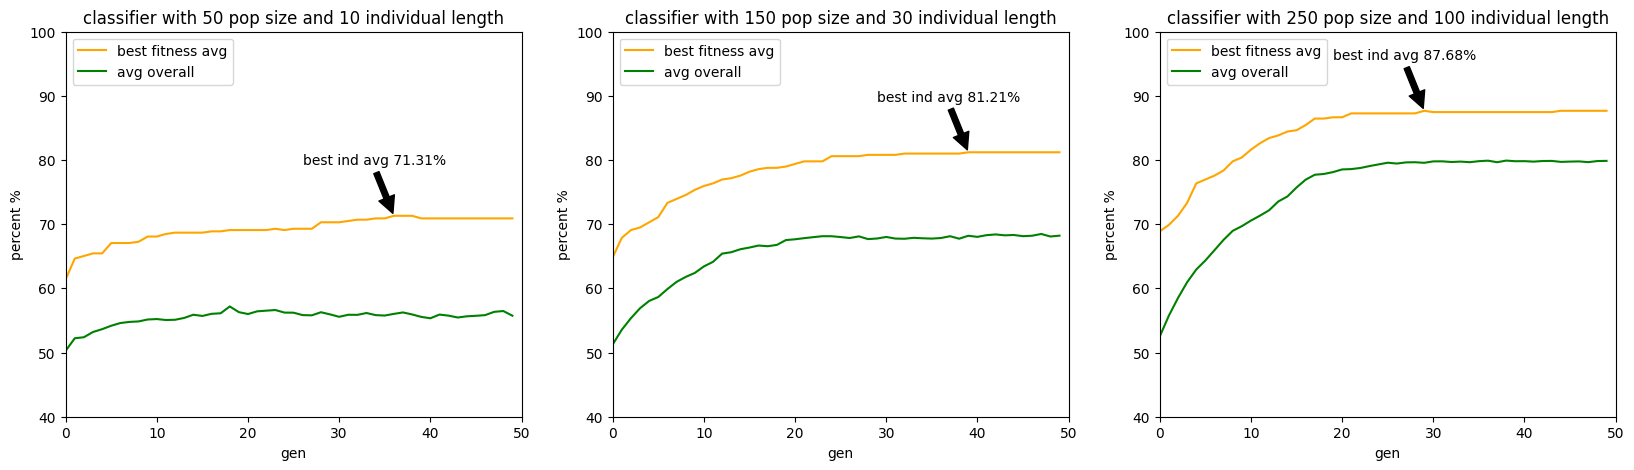

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
tittels = []
for i in range(len(pop_sizes)):
  title = f"classifier with {pop_sizes[i]} pop size and {ind_lens[i]} individual length"
  plt.subplot(1,len(pop_sizes),i+1)
  plt.plot(x,y1[i], color="orange")
  plt.plot(x,y2[i], color="green")
  plt.xlabel("gen")
  plt.ylabel("percent %")
  plt.axis([0,max_gen,40,100])
  plt.legend(['best fitness avg', 'avg overall'], loc='upper left')
  max_y = max(y1[i])
  max_x = y1[i].index(max_y)
  plt.annotate(f"best ind avg {max_y:.2f}%",xy=(max_x,max(y1[i])), xytext=(max_x-10,max(y1[i])+8),arrowprops=dict(facecolor = "black", shrink = 0.05))
  plt.title(title)
plt.show()
